# Change Point Detection

In [40]:
library(zoo)
library(imputeTS)
library(changepoint)
library(changepoint.np)
library(ggplot2)
library(reshape)
library(gridExtra)

Warning message:
"package 'changepoint.np' was built under R version 3.6.3"


## Auxiliary functions

Basic growth rate $r(t) = \frac{x(t+1)}{x(t)}$

In [ ]:
growthRate <- function(ts){
    # x(t) = head(x,-1)
    # x(t+1) = tail(x,-1)
    return(c(NaN,tail(ts,-1)/head(ts,-1)))
}

Normalized growth rate $r_N(t) = \frac{x(t+1)-x(t)}{x(t)}$

In [ ]:
growthRateNormalized <- function(ts){
    # x(t) = head(x,-1)
    # x(t+1) = tail(x,-1)
    return(c(NaN,(tail(ts,-1)-head(ts,-1))/head(ts,-1)))
}


In [ ]:
likelihoodCUSUM <- function(x_t,theta_0,theta_1){
    return(log(dnorm(x_t,theta_0$mu,theta_0$sigma)/dnorm(x_t,theta_1$mu,theta_1$sigma)))
}

In [ ]:
adaptiveCUSUM <- function(ts,k,splitting_point){
    # 1. Smooth the signal with a moving average of the k previous days (k being a parameter)
    ts_smooth <- rollmean(ts,k)
    # 2. Split into training/test data
    ts_smooth_train <- ts_smooth[1:splitting_point]
    ts_smooth_test <- ts_smooth[splitting_point:length(ts_smooth)]
    # 3. Estimate average and standard deviation (by sample average and sample standard deviation) in order to obtain theta_0 and theta_1
    theta_0 <- list(mu=mean(ts_smooth_train),sigma=sd(ts_smooth_train))
    theta_1 <- list(mu=mean(ts_smooth_test),sigma=sd(ts_smooth_test))
    # 4. Apply the CUSUM formulas (silde 61)
    s_t <- rollapply(ts,likelihoodCUSUM)
    S_t <- cumsum(s_t)
    m_t <- rollmin(s_t) 
}

In [5]:
splitData <- function(province_country_pair,data.df){
    data.df[data.df$Country.Region == province_country_pair[1]&
            data.df$Province.State == province_country_pair[2] 
            ,]
}

computeGrowthRate <- function(country.df,growth_rate_function){
    country.df$ConfirmedGrowthRate <- growth_rate_function(country.df$Confirmed)
    country.df$RecoveredGrowthRate <- growth_rate_function(country.df$Recovered)
    country.df$DeathsGrowthRate <- growth_rate_function(country.df$Deaths)
    return(country.df)
}


## Read data in

In [1]:
data.df <- readRDS("data/COVID19_Global_Italy_wGrowth.Rdata")

In [2]:
head(data.df)

,Province.State,Country.Region,Lat,Long,Date,Confirmed,Recovered,Deaths,HospitalizedWSymptoms,ICU,...,DailyConfirmed,Total,Tests,Lat.x,Long.x,Lat.y,Long.y,ConfirmedGrowthRate,RecoveredGrowthRate,DeathsGrowthRate
,<chr>,<chr>,<dbl>,<dbl>,<date>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
715,,Afghanistan,33,65,2020-01-22,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
716,,Afghanistan,33,65,2020-01-23,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
717,,Afghanistan,33,65,2020-01-24,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
718,,Afghanistan,33,65,2020-01-25,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
719,,Afghanistan,33,65,2020-01-26,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
720,,Afghanistan,33,65,2020-01-27,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN


## Split data accoring to unique Country-Province Pair

In [3]:
unique_pairs.df <- unique(data.df[,c("Country.Region","Province.State")])
unique_pairs.list <- mapply(c,unique_pairs.df$Country.Region,as.character(unique_pairs.df$Province.State), SIMPLIFY = FALSE)

In [6]:
split_data.list <- lapply(unique_pairs.list,splitData,data.df)

In [7]:
head(split_data.list[[1]])

,Province.State,Country.Region,Lat,Long,Date,Confirmed,Recovered,Deaths,HospitalizedWSymptoms,ICU,...,DailyConfirmed,Total,Tests,Lat.x,Long.x,Lat.y,Long.y,ConfirmedGrowthRate,RecoveredGrowthRate,DeathsGrowthRate
,<chr>,<chr>,<dbl>,<dbl>,<date>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
715,,Afghanistan,33,65,2020-01-22,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
716,,Afghanistan,33,65,2020-01-23,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
717,,Afghanistan,33,65,2020-01-24,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
718,,Afghanistan,33,65,2020-01-25,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
719,,Afghanistan,33,65,2020-01-26,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN
720,,Afghanistan,33,65,2020-01-27,0,0,0,NA,NA,...,NA,NA,NA,33,65,33,65,NaN,NaN,NaN


## Create a multivariate time series dataset

In [16]:
confirmed_gr_ts.list <- lapply(split_data.list,function(data.df){zoo(data.df[,c("ConfirmedGrowthRate")],order.by=as.Date(data.df$Date))})
confirmed_gr_ts.zoo <- Reduce(merge,confirmed_gr_ts.list)
colnames(confirmed_gr_ts.zoo) <- lapply(unique_pairs.list,paste,collapse="_")

In [17]:
dim(confirmed_gr_ts.zoo)

[1]  67 256

In [18]:
head(confirmed_gr_ts.zoo)

           Afghanistan_ Albania_ Algeria_ Andorra_ Angola_ Antigua and Barbuda_
2020-01-22          NaN      NaN      NaN      NaN     NaN                  NaN
2020-01-23          NaN      NaN      NaN      NaN     NaN                  NaN
2020-01-24          NaN      NaN      NaN      NaN     NaN                  NaN
2020-01-25          NaN      NaN      NaN      NaN     NaN                  NaN
2020-01-26          NaN      NaN      NaN      NaN     NaN                  NaN
2020-01-27          NaN      NaN      NaN      NaN     NaN                  NaN
           Argentina_ Armenia_ Australia_Australian Capital Territory
2020-01-22        NaN      NaN                                    NaN
2020-01-23        NaN      NaN                                    NaN
2020-01-24        NaN      NaN                                    NaN
2020-01-25        NaN      NaN                                    NaN
2020-01-26        NaN      NaN                                    NaN
2020-01-27        Na

## Explore data

In [35]:
confirmed_ts.zoo[,grepl("Italy|China",colnames(confirmed_ts.zoo))]

           China_Anhui China_Beijing China_Chongqing China_Fujian China_Gansu
2020-01-22           1            14               6            1           0
2020-01-23           9            22               9            5           2
2020-01-24          15            36              27           10           2
2020-01-25          39            41              57           18           4
2020-01-26          60            68              75           35           7
2020-01-27          70            80             110           59          14
2020-01-28         106            91             132           80          19
2020-01-29         152           111             147           84          24
2020-01-30         200           114             182          101          26
2020-01-31         237           139             211          120          29
2020-02-01         297           168             247          144          40
2020-02-02         340           191             300          15

In [12]:
data.df[data.df$Province.State == "Lombardia",]

,Province.State,Country.Region,Lat,Long,Date,Confirmed,Recovered,Deaths,HospitalizedWSymptoms,ICU,...,DailyConfirmed,Total,Tests,Lat.x,Long.x,Lat.y,Long.y,ConfirmedGrowthRate,RecoveredGrowthRate,DeathsGrowthRate
,<chr>,<chr>,<dbl>,<dbl>,<date>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,Lombardia,Italy,45.46679,9.190347,2020-02-24,166,0,6,76,19,...,166,172,1463,NA,NA,NA,NA,NaN,NaN,NaN
31,Lombardia,Italy,45.46679,9.190347,2020-02-25,231,0,9,79,25,...,65,240,3700,NA,NA,NA,NA,0.39156627,NaN,0.50000000
52,Lombardia,Italy,45.46679,9.190347,2020-02-26,249,0,9,79,25,...,18,258,3208,NA,NA,NA,NA,0.07792208,NaN,0.00000000
73,Lombardia,Italy,45.46679,9.190347,2020-02-27,349,40,14,172,41,...,100,403,3320,NA,NA,NA,NA,0.40160643,Inf,0.55555556
94,Lombardia,Italy,45.46679,9.190347,2020-02-28,474,40,17,235,47,...,125,531,4835,NA,NA,NA,NA,0.35816619,0.000000000,0.21428571
115,Lombardia,Italy,45.46679,9.190347,2020-02-29,552,40,23,256,80,...,78,615,5723,NA,NA,NA,NA,0.16455696,0.000000000,0.35294118
136,Lombardia,Italy,45.46679,9.190347,2020-03-01,887,73,24,406,106,...,335,984,6879,NA,NA,NA,NA,0.60688406,0.825000000,0.04347826
157,Lombardia,Italy,45.46679,9.190347,2020-03-02,1077,139,38,478,127,...,190,1254,7925,NA,NA,NA,NA,0.21420519,0.904109589,0.58333333
178,Lombardia,Italy,45.46679,9.190347,2020-03-03,1326,139,55,698,167,...,249,1520,9577,NA,NA,NA,NA,0.23119777,0.000000000,0.44736842


## Changepoint detection

In [ ]:
nations_with_missing_values <- which( apply(is.na(confirmed_gr_ts.zoo),2,sum) > 33, arr.ind = T)

### Subset only relevant data

In [33]:
start_date_Italy <- which(index(confirmed_gr_ts.zoo) == as.Date("2020-02-25"),arr.ind=T)
lombardy_gr.ts <- confirmed_gr_ts.zoo$Italy_Lombardia[start_date_Italy:length(confirmed_gr_ts.zoo$Italy_Lombardia)]

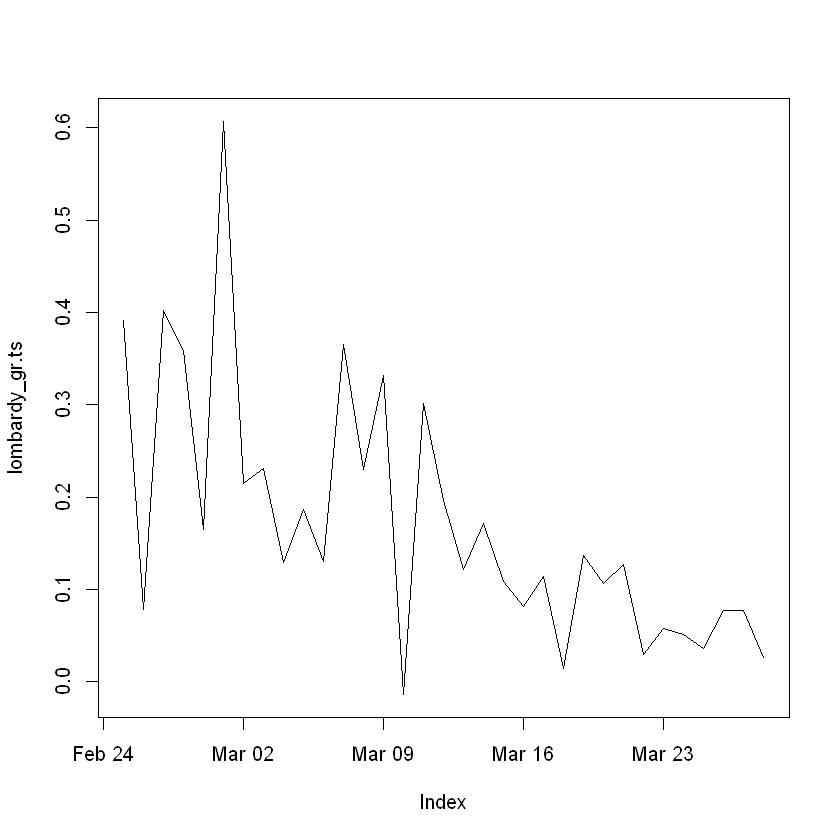

In [34]:
plot(lombardy_gr.ts)

### Mean-based change point detection

In [37]:
lombardy_gr.cpt <- cpt.mean(lombardy_gr.ts)
cpts(lombardy_gr.cpt)

numeric(0)

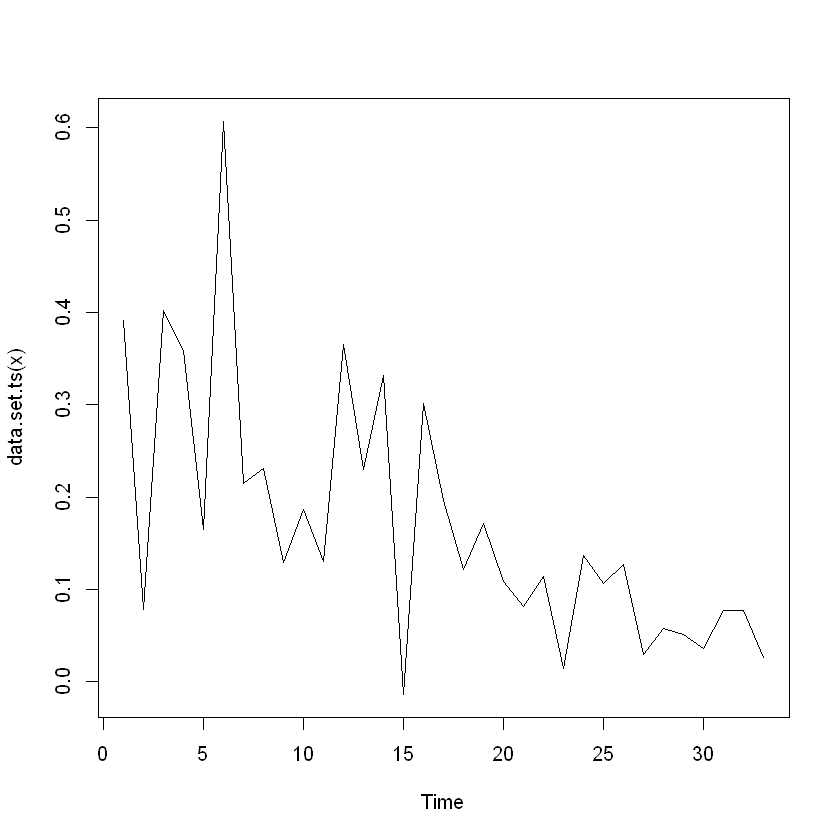

In [38]:
plot(lombardy_gr.cpt)

### Non-parametric change point detection

In [ ]:
lombardy_gr.cpt <- cpt.np(lombardy_gr.ts, method="PELT",minseglen=2, nquantiles =4*log(length(data)))
cpts(lombardy_gr.cpt)

In [ ]:
plot(lombardy_gr.cpt)

### Mean-var-vased change point detection

In [75]:
lombardy_gr.cpt <- cpt.meanvar(lombardy_gr.ts,test.stat='Normal',method='BinSeg',Q=10,penalty="SIC")
lombardy_changepoint <- cpts(lombardy_gr.cpt)

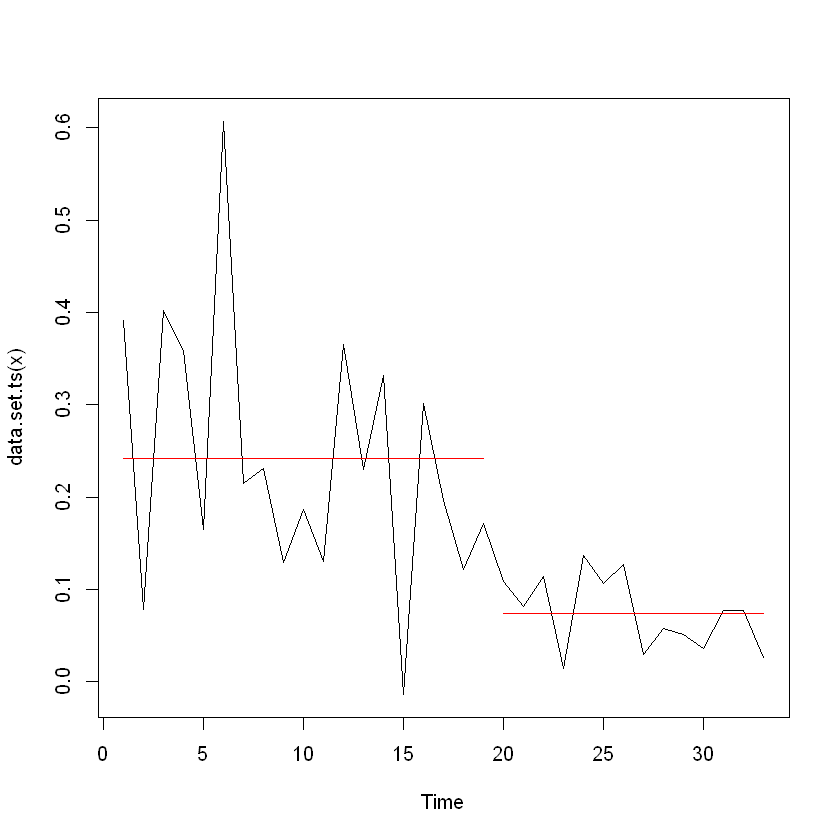

In [76]:
plot(lombardy_gr.cpt)

#### Custom-made ggplot graph

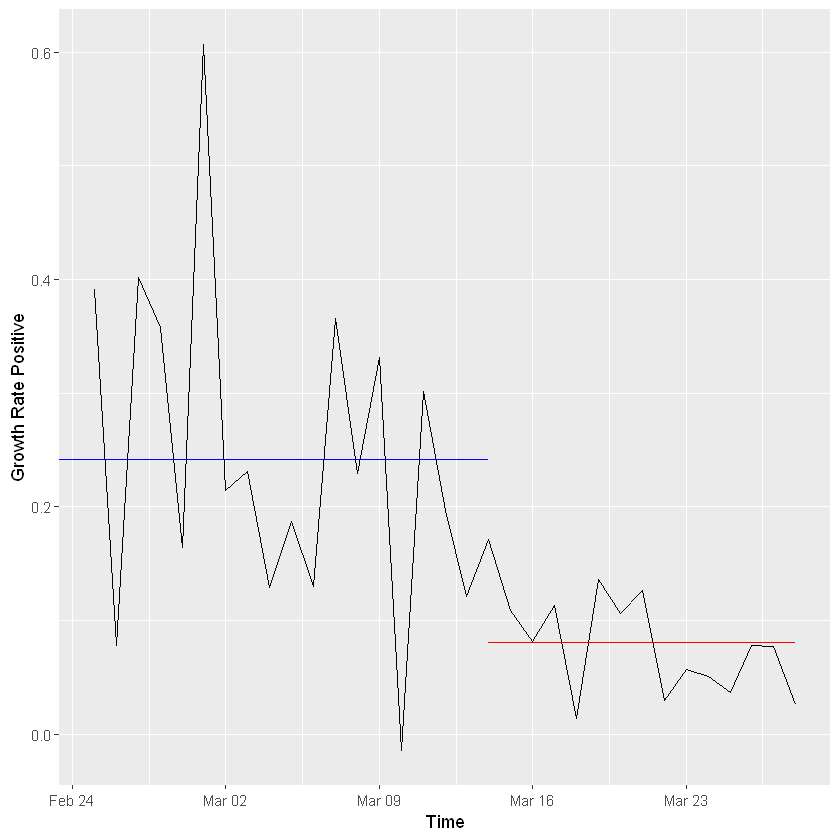

In [79]:
mean_before_cp <- mean(lombardy_gr.ts[1:lombardy_changepoint])
mean_after_cp <- mean(lombardy_gr.ts[lombardy_changepoint:length(lombardy_gr.ts)])
index_cp <- index(lombardy_gr.ts)[lombardy_changepoint]
index_last <- tail(index(lombardy_gr.ts),1)
                       
ggplot(fortify(lombardy_gr.ts,melt=T),aes(x=Index,y=Value)) +
    geom_line() +
    geom_segment(x=1,
                 xend=index_cp,
                 y=mean_before_cp,
                 yend=mean_before_cp,
                 color="blue") +
   geom_segment(x=index_cp,
                 xend=index_last,
                 y=mean_after_cp,
                 yend=mean_after_cp,
                 color="red") +
  labs(x="Time",y="Growth Rate Positive")